In [1]:
import gym
import navstack_gym
import numpy as np
import matplotlib.pyplot as plt

from collections import deque
from gym.wrappers import TimeLimit
from pprint import pprint as p
import h5py
import pfrl
import torch

from gym.wrappers import TimeLimit, FrameStack
from algo.wrapper import ResizeObservation, TensorObservation

from algo import utils
from algo.agent import make_DrQ_agent

In [2]:
################# Task Setting ####################
# reference ./conf/ 
TARGET = 'map_explore_with_random_env'
EXPERIMENT_NAME = 'subtask_map_random_ft'
###################################################

cfg = utils.load_param('conf', 'train_config.yaml', [f'task={TARGET}', f'experiment_name={EXPERIMENT_NAME}'])

workspace_path = utils.get_workspace_path(cfg.experiment_name)

p(cfg)
env_mode = cfg.env_config.full
room_mode = cfg.room_config.hodoyoi

gpu = torch.cuda.current_device() if torch.cuda.is_available() else -1

env = gym.make(cfg.env_id, **env_mode)
env = ResizeObservation(env, cfg.observation_resize)
env = FrameStack(env, cfg.stack_num)
env = TensorObservation(env)
env = TimeLimit(env, max_episode_steps=cfg.max_episode_steps)

print(f'timelimit: \t{env.spec.max_episode_steps}')
print(f'obs_space: \t{env.observation_space.shape} \naction_space: \t{env.action_space.shape}')
print(f'obs_size: \t{env.observation_space.low.size}')
print(f'action_size: \t{env.action_space.low.size}')
print(f'obs_stack: \t{cfg.stack_num}')

if cfg.set_seed:
    np.random.seed(cfg.env_seed)
    
obs = env.reset(**room_mode)

agent = make_DrQ_agent(
    experiment_name=cfg.experiment_name, 
    obs_space=env.observation_space, 
    action_space=env.action_space,
    feature_dim=cfg.feature_dim,
    hidden_dim=cfg.hidden_dim,
    lr=cfg.lr,
    image_pad=cfg.image_pad,
    gamma=cfg.gamma,
    replay_start_size=cfg.replay_start_size,
    capacity=cfg.capacity,
    gpu=gpu,
    batch_size=cfg.batch_size,
    update_interval=cfg.update_interval,
    is_persistent_buffer=False)

{'room_config': {'easy': {'scene_obstacle_count': 10, 'scene_obstacle_size': 0.7, 'scene_target_size': 0.2, 'scene_key_size': 0.2, 'scene_obstacle_zone_thresh': 1.5, 'scene_distance_key_placing': 0.7, 'scene_range_key_placing': 0.3, 'scene_room_length_max': 9, 'scene_room_wall_thickness': 0.05, 'scene_wall_threshold': 0.1}, 'crowded': {'scene_obstacle_count': 15, 'scene_obstacle_size': 0.6, 'scene_target_size': 0.2, 'scene_key_size': 0.2, 'scene_obstacle_zone_thresh': 1.5, 'scene_distance_key_placing': 0.7, 'scene_range_key_placing': 0.3, 'scene_room_length_max': 9, 'scene_room_wall_thickness': 0.05, 'scene_wall_threshold': 0.1}, 'hodoyoi': {'scene_obstacle_count': 13, 'scene_obstacle_size': 0.6, 'scene_target_size': 0.3, 'scene_key_size': 0.2, 'scene_obstacle_zone_thresh': 1.0, 'scene_distance_key_placing': 0.7, 'scene_range_key_placing': 0.3, 'scene_room_length_max': 9, 'scene_room_wall_thickness': 0.05, 'scene_wall_threshold': 0.2}}, 'env_config': {'zantei': {'map_size': 128, 'map_r

/home/tagokeniot/tmp/.venv/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/tagokeniot/tmp/wrapper.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  return torch.as_tensor(observation, dtype=torch.float32)


set workspace: work/subtask_map_random_ft


In [3]:
agent.load(str(workspace_path/'agent'))

/home/tagokeniot/tmp/.venv/lib/python3.8/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +
/home/tagokeniot/tmp/.venv/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/tagokeniot/tmp/.venv/lib/python3.8/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


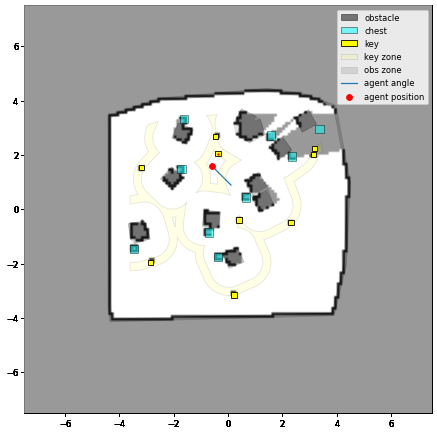

In [4]:
frames = []
np.random.seed(55)
obs = env.reset(**room_mode, is_generate_room=cfg.change_room, is_generate_pose=cfg.change_pose)

frames.append(env.render('rgb_array'))
R = 0
done = False
t = 0

with agent.eval_mode():
    while (not done) and (t < cfg.max_episode_steps):
        action = agent.act(obs)
        obs, r, done, info = env.step(action)
        frames.append(env.render('rgb_array'))
        R += r
        reset = t == cfg.max_episode_steps
        agent.observe(obs, r, done, reset)
        t += 1

In [6]:
for i in range(len(frames)):
    plt.imsave(f'tmpmov/{i}.png', frames[i])

In [5]:
print(R)
utils.display_frames_as_gif(frames, f'{cfg.experiment_name}!.gif')

181.54536975349768


In [14]:
eval_count = 10

In [15]:
t_rewards = np.zeros([eval_count, cfg.max_episode_steps])
t_states = np.zeros([eval_count, cfg.max_episode_steps, obs.shape[0], obs.shape[1], obs.shape[2]])
t_agent_trajectories = np.zeros([eval_count, cfg.max_episode_steps, 3])
t_goal_trajectories = np.zeros([eval_count, cfg.max_episode_steps, 3])
t_start_agent_poses = np.zeros([eval_count, 3])
t_start_maps = np.zeros([eval_count, obs.shape[1], obs.shape[2]])

frames = []

/home/tagokeniot/tmp/.venv/lib/python3.8/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +
/home/tagokeniot/tmp/.venv/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/tagokeniot/tmp/.venv/lib/python3.8/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


(540, 540, 4)

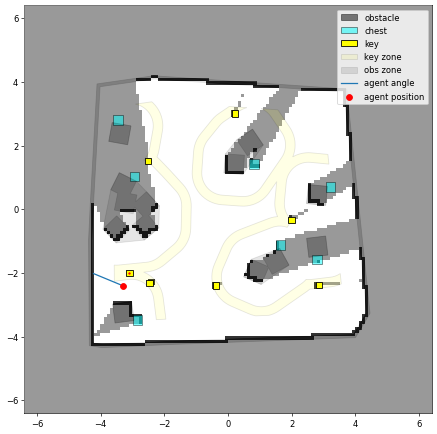

In [21]:
env.render('rgb_array').shape

In [17]:
with agent.eval_mode():
    for i in range(eval_count):
        obs = env.reset(**room_mode, is_generate_room=cfg.change_room, is_generate_pose=cfg.change_pose)
        R = 0
        done = False
        t = 0
        while (not done) and (t < cfg.max_episode_steps):
            action = agent.act(obs)
            obs, r, done, info = env.step(action)
            R += r
            reset = t == cfg.max_episode_steps
            agent.observe(obs, r, done, reset)

            t_states[i,t] = obs
            t_rewards[i,t] = r
            t_agent_trajectories[i,t] = env.agent_current_position
            t_goal_trajectories[i,t] = info['goal']
            t += 1

            if done or reset:
                break

In [31]:
np.sum(t_rewards, axis=1)

array([-2., -2., -2., -2., -2., -2., -2., -2., -2., -2.])